In [26]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import geopandas as gpd

from shapely.geometry import Point, Polygon, shape

<Axes: >

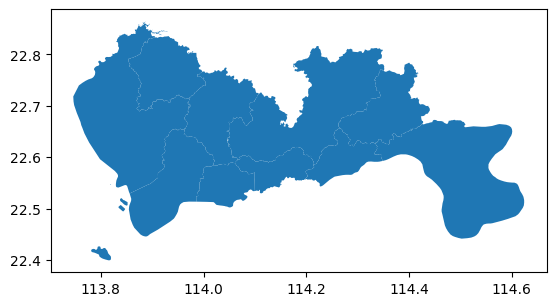

In [27]:
shp = r'../shapefile/sz.shp'
xzqh = gpd.GeoDataFrame.from_file(shp, encoding='utf-8')
xzqh.plot()

In [28]:
# 读取栅格数据
shp = r'../shapefile/grid/grid.shp'
grid = gpd.GeoDataFrame.from_file(shp, encoding='gbk')
# 根据栅格数据求解几何中心
grid['centroid'] = grid.centroid
# print(grid.head())
# 提取的OD数据
OD = pd.read_csv(r'../data-sample/taxi_od_grid.csv')
# 空间链接
grid = gpd.sjoin(grid, xzqh, how='inner', op='intersects')
grid.head()

c:\Users\Beck\.conda\envs\torch\Lib\site-packages\IPython\core\interactiveshell.py:3493: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,LONCOL,LATCOL,HBLON,HBLAT,geometry,centroid,index_right,centroid_x,centroid_y,qh
0,0,54,113.749504,22.688405,"POLYGON ((113.74707 22.68616, 113.74707 22.690...",POINT (113.74950 22.68841),3,113.851387,22.67912,宝安
1,0,55,113.749504,22.692902,"POLYGON ((113.74707 22.69065, 113.74707 22.695...",POINT (113.74950 22.69290),3,113.851387,22.67912,宝安
2,0,56,113.749504,22.697399,"POLYGON ((113.74707 22.69515, 113.74707 22.699...",POINT (113.74950 22.69740),3,113.851387,22.67912,宝安
3,0,57,113.749504,22.701895,"POLYGON ((113.74707 22.69965, 113.74707 22.704...",POINT (113.74950 22.70190),3,113.851387,22.67912,宝安
4,0,58,113.749504,22.706392,"POLYGON ((113.74707 22.70414, 113.74707 22.708...",POINT (113.74950 22.70639),3,113.851387,22.67912,宝安


In [31]:
grid_point = grid[['LONCOL', 'LATCOL', 'centroid', 'qh']].copy()
grid_point = grid_point.rename(columns={
    'LONCOL': 'lon_index',
    'LATCOL': 'lat_index',
    'qh' : 'area'
})
# 提取路径对应的起始终止网格
temp_grid = grid_point.copy()
temp_grid.columns=[
    'SLONCOL', 'SLATCOL', 's_cent', 's_area'
]
OD_temp = pd.merge(OD, temp_grid, on=['SLONCOL', 'SLATCOL'])
temp_grid.columns=[
    'ELONCOL', 'ELATCOL', 'e_cent', 'e_area'
]
OD_line = pd.merge(OD_temp, temp_grid, on=['ELONCOL', 'ELATCOL'])
OD_line = OD_line.groupby([
    's_cent', 's_area',
    'e_cent', 'e_area'
]).sum().reset_index()
# 去除非跨区OD
OD_line = OD_line[-(OD_line['s_area']==OD_line['e_area'])]
OD_line.head()

,s_cent,s_area,e_cent,e_area,SLONCOL,SLATCOL,ELONCOL,ELATCOL,VehicleNum
3,POINT (113.85670 22.55800),宝安,POINT (113.92979 22.51753),南山,22,25,37,16,1
6,POINT (113.86157 22.55800),宝安,POINT (113.91517 22.53552),南山,23,25,34,20,1
7,POINT (113.86157 22.55800),宝安,POINT (113.93466 22.54451),南山,23,25,38,22,1
8,POINT (113.86157 22.55800),宝安,POINT (114.02237 22.62545),龙华,23,25,56,40,1
9,POINT (113.86157 22.55800),宝安,POINT (113.93954 22.54901),南山,23,25,39,23,1


In [ ]:
# 绘制路径图
import matplotlib as mpl
import matplotlib.pyplot as plt

fig = plt.figure(1, (10, 8), dpi=250)
ax = plt.subplot(111)
plt.sca(ax)
